# Continuously Stirred Reactor (Periodic)

Code is ported (almost) verbatim from cantera example file `periodic_cstr.py` (distributed with cantera):
```
"""
This example illustrates a continuously stirred tank reactor (CSTR) with steady
inputs but periodic interior state.

A stoichiometric hydrogen/oxygen mixture is introduced and reacts to produce
water.  But since water has a large efficiency as a third body in the chain
termination reaction

       H + O2 + M = HO2 + M

as soon as a significant amount of water is produced the reaction stops. After
enough time has passed that the water is exhausted from the reactor, the mixture
explodes again and the process repeats. This explanation can be verified by
decreasing the rate for reaction 7 in file 'h2o2.cti' and re-running the
example.

Acknowledgments: The idea for this example and an estimate of the conditions
needed to see the oscillations came from Bob Kee, Colorado School of Mines
"""
```

In [1]:
import cantera as ct
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

### Problem Setup

In [2]:
# create the gas mixture
gas = ct.Solution('h2o2.cti')

# pressure = 60 Torr, T = 770 K
p = 60.0*133.3
t = 770.0

gas.TPX = t, p, 'H2:2, O2:1'

# create an upstream reservoir that will supply the reactor. The temperature,
# pressure, and composition of the upstream reservoir are set to those of the
# 'gas' object at the time the reservoir is created.
upstream = ct.Reservoir(gas)

# Now create the reactor object with the same initial state
cstr = ct.IdealGasReactor(gas)

# Set its volume to 10 cm^3. In this problem, the reactor volume is fixed, so
# the initial volume is the volume at all later times.
cstr.volume = 10.0*1.0e-6

# We need to have heat loss to see the oscillations. Create a reservoir to
# represent the environment, and initialize its temperature to the reactor
# temperature.
env = ct.Reservoir(gas)

# Create a heat-conducting wall between the reactor and the environment. Set its
# area, and its overall heat transfer coefficient. Larger U causes the reactor
# to be closer to isothermal. If U is too small, the gas ignites, and the
# temperature spikes and stays high.
w = ct.Wall(cstr, env, A=1.0, U=0.02)

# Connect the upstream reservoir to the reactor with a mass flow controller
# (constant mdot). Set the mass flow rate to 1.25 sccm.
sccm = 1.25
vdot = sccm * 1.0e-6/60.0 * ((ct.one_atm / gas.P) * ( gas.T / 273.15)) # m^3/s
mdot = gas.density * vdot # kg/s
mfc = ct.MassFlowController(upstream, cstr, mdot=mdot)

# now create a downstream reservoir to exhaust into.
downstream = ct.Reservoir(gas)

# connect the reactor to the downstream reservoir with a valve, and set the
# coefficient sufficiently large to keep the reactor pressure close to the
# downstream pressure of 60 Torr.
v = ct.Valve(cstr, downstream, K=1.0e-9)

# create the network
network = ct.ReactorNet([cstr])

### Time Integration

In [3]:
# now integrate in time
t = 0.0
dt   = 0.1

states = ct.SolutionArray(gas, extra=['t'])
while t < 300.0:
    t += dt
    network.advance(t)
    states.append(cstr.thermo.state, t=t)

### Results

<IPython.core.display.Javascript object>


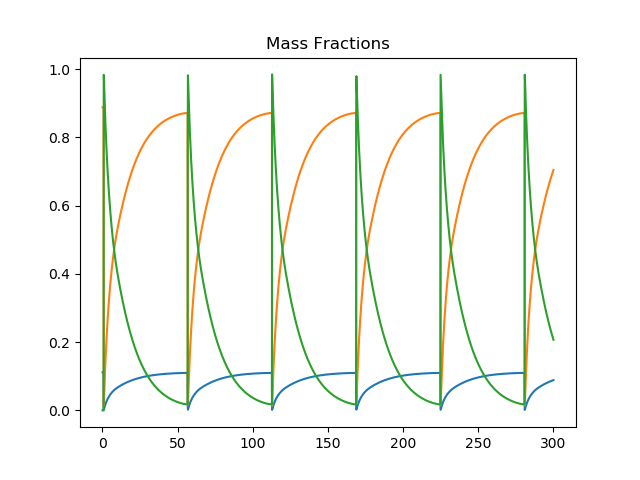

In [4]:
plt.figure(1)
plt.plot(states.t, states('H2','O2','H2O').Y)
_ = plt.title('Mass Fractions')